<a href="https://colab.research.google.com/github/moonman239/Capstone-project/blob/test2/Capstone_project_merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install symspellpy
!pip3 install keras_bert
!pip3 install wordcloud
!wget -nc https://github.com/moonman239/Capstone-project/raw/master/data.zip -O data.zip
!unzip data.zip
!pip3 install -q keras-bert
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

     |████████████████████████████████| 2.6MB 2.8MB/s 
  Created wheel for keras-bert: filename=keras_bert-0.85.0-cp36-none-any.whl size=34303 sha256=309007829081827e8b715baf031b89f97a46338bcbcbf05c1c1aaa82e850e32a
  Stored in directory: /root/.cache/pip/wheels/1f/7a/13/40e59e2587ebfdba717d5ecc4c89c614f06c8137e515fa8b26
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12942 sha256=0d8815cf5a5e448249cec5f60bed98b1d76f3d3e4d7e60c86112d2479a82d3e7
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=11f3e8c969e8a8896833a2ede0c5265f02bf59738f60a7e747a97c15a5c03d38
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15611 sha256=3cf8ea9f0489f041

## Setup

Load Python modules.

In [ ]:

import numpy as np
import pandas as pd
import os
# TF_KERAS must be added to environment variables in order to use TPU
os.environ['TF_KERAS'] = '1'
from tensorflow.python.client import device_lib
import tensorflow.compat.v1 as tf
#import keras
from tensorflow.keras.layers import Embedding,Dropout,Lambda,Dense,Input,InputLayer,LSTM,Concatenate,Flatten,Add,Reshape,GlobalAveragePooling1D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import sys
assert sys.version_info[0] >= 3
#from keras.backend import slice
print(tf.VERSION)
print(tf.keras.__version__)
print("Modules loaded!")

2.2.0
2.3.0-tf
Modules loaded!


In [ ]:
import sys
print(sys.version)

# Preprocessing

For the preprocessing step, we will create two Pandas DataFrames - one for the training data, and another for the test (dev) data.

## Data preprocessing techniques

In order to ensure the invariance of the text, I will need to train my deep & LSTM neural networks on lower-cased data, with punctuation removed if feasibly possible.

Natural language processing suffers from a dearth of data. I have heard that a useful technique for overcoming this problem is to create inverted data. For example, given sentence "I used to live all over Europe. In fact, I spent a significant amount of time in France, and now I speak fluent French.", we might also add the sentence "French fluent speak I now and France in time of amount significant a spent I fact in Europe over all live to used I"

### Loading JSON datasets

In [ ]:

assert os.path.isfile("train-v1.1.json"),"Non-existent file"
print("JSON datasets downloaded.")

JSON datasets downloaded.


In [ ]:
import json
import re
regex = re.compile(r'\W+')
def readFile(filename):
  with open(filename) as file:
    fields = []
    JSON = json.loads(file.read())
    articles = []
    for article in JSON["data"]:
      articleTitle = article["title"]
      article_body = []
      for paragraph in article["paragraphs"]:
        paragraphContext = paragraph["context"]
        article_body.append(paragraphContext)
        for qas in paragraph["qas"]:
          question = qas["question"]
          answer = qas["answers"][0]
          fields.append({"question":question,"answer_text":answer["text"],"answer_start":answer["answer_start"],"paragraph_context":paragraphContext,"article_title":articleTitle})
      article_body = "\\n".join(article_body)
      article = {"title":articleTitle,"body":article_body}
      articles.append(article)
  fields = pd.DataFrame(fields)
  fields["question"] = fields["question"].str.replace(regex," ")
  assert not (fields["question"].str.contains("catalanswhat").any())
  fields["paragraph_context"] = fields["paragraph_context"].str.replace(regex," ")
  fields["answer_text"] = fields["answer_text"].str.replace(regex," ")
  assert not (fields["paragraph_context"].str.contains("catalanswhat").any())
  fields["article_title"] = fields["article_title"].str.replace("_"," ")
  assert not (fields["article_title"].str.contains("catalanswhat").any())
  return fields,JSON["data"]

In [ ]:
trainingData,training_JSON = readFile("train-v1.1.json")
devData,dev_articles = readFile("dev-v1.1.json")

In [ ]:
from pprint import pprint
pprint(training_JSON[0:5])

Streaming output truncated to the last 5000 lines.
                                                'Public Interest'}],
                           'id': '56bfda91a10cfb140055133a',
                           'question': 'Who sent her a letter asking that she '
                                       'reconsider the Pepsi deal?'},
                          {'answers': [{'answer_start': 24, 'text': 'Pepsi'}],
                           'id': '56d4ec422ccc5a1400d83362',
                           'question': 'What soft drink company has Beyoncé '
                                       'worked with since 2002?'},
                          {'answers': [{'answer_start': 171,
                                        'text': '$50 million'}],
                           'id': '56d4ec422ccc5a1400d83363',
                           'question': 'How much did Beyoncé get for a deal '
                                       'with a soft drink company in 2012?'},
                          {'answers': [{'

### Convert strings to lowercase.

In [ ]:
#@title
def lowercase(data):
  data["question"] = data["question"].str.lower()
  data["article_title"] = data["article_title"].str.lower()
  data["paragraph_context"] = data["paragraph_context"].str.lower()
  data["answer_text"] = data["answer_text"].str.lower()
  return data


In [ ]:
trainingData = lowercase(trainingData)
devData = lowercase(devData)

## Create more data

In [ ]:
def invert_string(string):
	string_array = string.split(" ")
	string_array.reverse()
	return " ".join(string_array)
invert_string = np.vectorize(invert_string)
def invert_series_of_strings(series):
  return pd.Series(invert_string(series.values))
def createMoreData(dataFrame):
	newDataFrameQuestions = dataFrame["question"].append(invert_series_of_strings(dataFrame["question"]),ignore_index=True)
	newDataFrameArticleTitles = dataFrame["article_title"].append(invert_series_of_strings(dataFrame["article_title"]),ignore_index=True)
	newDataFrameParagraphContexts = dataFrame["paragraph_context"].append(dataFrame["paragraph_context"],ignore_index=True)
	newDataFrameAnswerStarts = dataFrame["answer_start"].append(dataFrame["answer_start"],ignore_index=True)
	return pd.DataFrame(data={"question":newDataFrameQuestions,"paragraph_context":newDataFrameParagraphContexts,"article_title":newDataFrameArticleTitles,"answer_start":newDataFrameAnswerStarts})

In [ ]:
trainingData = createMoreData(trainingData)

In [ ]:
devData = createMoreData(devData)

In [ ]:
print(trainingData.shape)

## Convert answer_starts to numeric.

In [ ]:
trainingData["answer_start"] = pd.to_numeric(trainingData["answer_start"])
devData["answer_start"] = pd.to_numeric(devData["answer_start"])

## Dataset output

In [ ]:
trainingData[["question","paragraph_context","article_title","answer_start"]]

In [ ]:
devData

In [ ]:
print(trainingData.dtypes)

In [ ]:
#@title
devData["question"] = devData["question"].str.lower()
devData["article_title"] = devData["article_title"].str.lower()
devData["paragraph_context"] = devData["paragraph_context"].str.lower()
#devData["answer_text"] = devData["answer_text"].str.lower()
devData["answer_start"] = pd.to_numeric(devData["answer_start"])
print("Finished loading dev data and lowering appropriate columns.")

## Getting training data?

In [ ]:
X_2_train = trainingData[["question","paragraph_context"]]
Y_2_train = trainingData["answer_start"]

### Integer encode text

Used for manual encoding of text into integers.

In [ ]:
strings = pd.concat((trainingData,devData)).drop("answer_start",axis=1)
strings = strings.values.flatten()
textTokenizer = Tokenizer()
textTokenizer.fit_on_texts(strings)

In [ ]:
# Get length of vocabulary.
vocabulary_length = len(textTokenizer.word_index) + 1

In [ ]:
questionsTokenized_train = pad_sequences(textTokenizer.texts_to_sequences(trainingData["question"]))
contextTokenized_train = pad_sequences(textTokenizer.texts_to_sequences(trainingData["paragraph_context"]))

In [ ]:
questionsTokenized_dev = pad_sequences(textTokenizer.texts_to_sequences(devData["question"]))
contextTokenized_dev = pad_sequences(textTokenizer.texts_to_sequences(devData["paragraph_context"]))

In [ ]:
articleTitles_train = pad_sequences(textTokenizer.texts_to_sequences(trainingData["article_title"]))

In [ ]:
articleTitles_dev = pad_sequences(textTokenizer.texts_to_sequences(devData["article_title"]))

### One-hot encoding answer_start

In [ ]:
answer_start_one_hot = pd.get_dummies(pd.concat((trainingData["answer_start"],devData["answer_start"])))

In [ ]:
answer_start_train_one_hot = pd.get_dummies(trainingData["answer_start"])

In [ ]:
#@title Shape of answer_start
print(trainingData["answer_start"].values.shape)

(175198,)


# Code to strip punctuation from strings

In [ ]:
import string
def removePunctuation(s):
  return s.translate(str.maketrans('', '', string.punctuation))

#Exploratory Visualizations & Statistics

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
data_frame = trainingData + devData
data_frame = data_frame.astype("str")

In [ ]:
question_vectorizer = CountVectorizer().fit(data_frame["question"])
context_vectorizer = CountVectorizer().fit(data_frame["paragraph_context"])
title_vectorizer = CountVectorizer().fit(data_frame["article_title"])

In [ ]:
def removeNonAlphanumericCharacters(string):
  import re
  regex = re.compile('[^a-zA-Z]')
  #First parameter is the replacement, second parameter is your input string
  return regex.sub('', string)
  #Out: 'abdE'

In [ ]:
def vocabulary_array(vocabulary_dictionary,strip_chars=False): # Returns an np.array with the word in the first column and the frequency in the second column.
  vocabulary = []
  for word,frequency in vocabulary_dictionary.items():
    if (strip_chars):
      word = removeNonAlphanumericCharacters(word)
    vocabulary.append([word,str(frequency)])
  vocabulary = np.array(vocabulary)
  return vocabulary[np.argsort(vocabulary[:,1])[::-1]]

In [ ]:
question_words = vocabulary_array(question_vectorizer.vocabulary_,strip_chars=True)
print(question_words[:,1][0:10].astype(np.uint64))

[9999 9998 9997 9996 9995 9994 9993 9992 9991 9990]


In [ ]:
print(question_words[:,0][0:10])

['khan' 'khalifah' 'khalifa' 'khagan' 'khadan' 'kgs' 'kg' 'keys'
 'keyboards' 'keyboard']


## Bar charts

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.subplots_adjust(top=0.8)

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Bar plot of most frequent words.
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(
    width=800,height=800,
    stopwords = set(STOPWORDS),
    min_font_size = 10,
    background_color='white'
).generate(" ".join(pd.concat((trainingData["paragraph_context"],devData["answer_text"])).values.tolist())) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

KeyboardInterrupt: ignored

(array([ 272., 1864., 2982., 2704., 1309.,  536.,  232.,   69.,   24.,
           8.]),
 array([ 13. ,  28.3,  43.6,  58.9,  74.2,  89.5, 104.8, 120.1, 135.4,
        150.7, 166. ]),
 <a list of 10 Patch objects>)

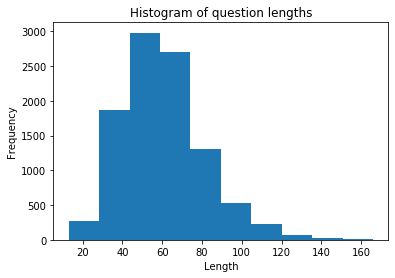

In [ ]:
#@title Bar plots of lengths.
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Histogram of question lengths")
plt.hist(trainingData["question"].str.len().values[0:10000])

(array([1.954e+03, 3.857e+03, 2.500e+03, 1.113e+03, 3.600e+02, 1.510e+02,
        6.000e+01, 0.000e+00, 1.000e+00, 4.000e+00]),
 array([ 147. ,  429.3,  711.6,  993.9, 1276.2, 1558.5, 1840.8, 2123.1,
        2405.4, 2687.7, 2970. ]),
 <a list of 10 Patch objects>)

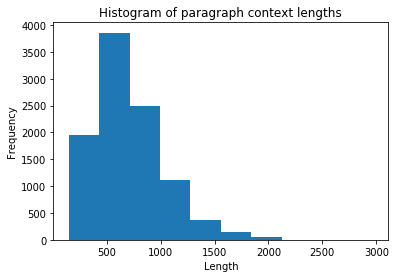

In [ ]:
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Histogram of paragraph context lengths")
plt.hist(trainingData["paragraph_context"].str.len().values[0:10000])

(array([1703., 1933., 2888.,  347., 1734.,    0.,  500.,  390.,  214.,
         291.]),
 array([ 3. ,  7.3, 11.6, 15.9, 20.2, 24.5, 28.8, 33.1, 37.4, 41.7, 46. ]),
 <a list of 10 Patch objects>)

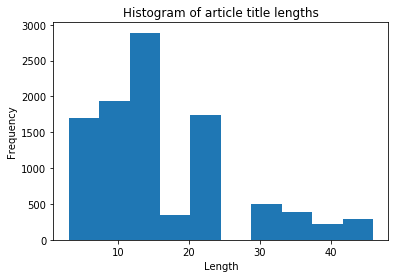

In [ ]:
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Histogram of article title lengths")
plt.hist(trainingData["article_title"].str.len().values[0:10000])

In [ ]:
wordcloud = WordCloud(
    width=800,height=800,
    stopwords = set(STOPWORDS),
    min_font_size = 10,
    background_color='white'
).generate(" ".join(pd.concat((trainingData["answer_text"],devData["answer_text"])).values.tolist())) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Histogram of answer lengths")
plt.hist(trainingData["answer_text"].str.len().values[0:10000])

### Other statistics

In [ ]:
from sys import getsizeof
def vocabularySize():
  return len(vocabulary())
def summaryStatistics(series):
    numberOfWords = series.apply(lambda x: len(str(x).split(" ")))
    averageNumberOfWords = sum(numberOfWords) / len(numberOfWords)
    return "average: " + str(averageNumberOfWords) + "maximum: " + str(max(numberOfWords)) + " minimum: " +str(min(numberOfWords))
print("Size of vocabulary: ", vocabularySize())
print("Words in each question: ",summaryStatistics(trainingData["question"]))
print("Words in each article title: ",summaryStatistics(trainingData["article_title"]))
print("Words in each context: ",summaryStatistics(trainingData["paragraph_context"]))
print("Words in each answer: ",summaryStatistics(trainingData["answer_text"]))

In [ ]:
#@title Top ten most frequently occuring words:
def wordFrequencies(series):
  split_strings = series.str.split(" ")
  frequencies = {}
  for split_string in split_strings:
    for word in split_string:
      word = word.lower()
      word = removePunctuation(word)
      try:
        frequencies[word] = frequencies[word] + 1
      except KeyError as k:
        frequencies[word] = 1
  return frequencies
pd.DataFrame.from_dict(wordFrequencies(trainingData["question"]))

#Building neural networks

This kind of task requires a neural network to find the answer from the relevant article. In this section, we look at two kinds of neural networks.

## Dense Neural Networks

This is the most basic, unremarkable kind of network. Put simply, each layer of this network takes inputs, applies weights and biases, then outputs a value between 0 and 1 - usually either a sigmoid value or a linear function.

## Long Short-Term Memory Networks


Long short-term memory networks are a type of recurrent neural networs that work by recalling words it previously read to get a good feel for the context of a word or phrase.

The most fundamental unit of an LSTM is the cell state - a little unit that holds information the LSTM deems important to remember. For example, consider the following piece of text:

"I used to live all over Europe. In fact, I spent a significant amount of time in France, and now I speak fluent _____." To fill in this blank, we only need to remember two things:

1) The preceding phrase "I speak fluent" - this indicates that the word that follows is the name of a language.
2) That the speaker lived in France; the fact that he lived "all over Europe" is irrelevant to deducing the name of the language he is about to mention he is fluent in.

We can thus deduce that the word that fits in the blank is "French". 

Part of the training process of an LSTM that would fill in the blank would involve learning which of these words would be important to deducing the missing word. For example, on the first training iteration, the LSTM might decide that all of the words are important. However, we might hope that as the LSTM progresses, it narrows down the list of words to remember to "France","I","speak", and "fluent". (https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e)

## Google BERT


As we will see, my LSTM model performed very poorly. One of the best models for learning relationships between words is Google's "Bidirectional Encoder Representations from Transformers" model.

One of the problems that BERT attempts to solve is the dearth of sufficient reliable training data for natural language processing tasks. It does this by manipulating existing data to create more data. For example, if our training data includes the sentence "I used to live all over Europe. In fact, I spent a significant amount of time in France, and now I speak fluent French," BERT will generate another sentence, such as: French fluent speak I now and France in time of amount significant a spent I fact in Europe over all live to used I". (https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

## Benchmark
  

Since my simplest model is a Dense model, I will use that as a benchmark.

## Defining metrics



First, we need to define a metric we can use to score our neural network.

We'll use the F1 score. This score emphasizes false positives and false negatives, and therefore should be used when they are most important. (https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2#:~:targetText=Accuracy%20is%20used%20when%20the,and%20False%20Positives%20are%20crucial&targetText=In%20most%20real%2Dlife%20classification,to%20evaluate%20our%20model%20on.)

In [ ]:
#@title F1
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Mapping Questions to Article Titles



While this step is likely important in a regular search, I do not expect that Stanford evaluates a program's ability to search for article titles; therefore, I am omitting this step for now.

## Mapping Questions and Paragraph Contexts to Answers

This neural network is used to generate answers from the questions and articles. It works by first reading the relevant article and using the question to find the answer.

## Word2Vec

In [ ]:

from tensorflow.keras.preprocessing.text import *
from tensorflow.keras.preprocessing.sequence import skipgrams,make_sampling_table
def skipgrams_labels(sequence,vocabulary_length,window_size=3):
    try:
        couples,labels = skipgrams(sequence,vocabulary_length,window_size=window_size)
        assert len(couples) > 0
        target_word,context = zip(*couples)
        return np.array([target_word,context,labels]).T
    except Exception as e:
        raise ValueError("Exception in skipgrams_labels")
# This is to train word2vec.
def word2vec_batch(sequences,vocabulary_length,batch_size=20):
    batch_indices = np.random.choice(sequences.shape[0], batch_size, replace=False)
    assert sequences.ndim == 2
    skipgrams_and_labels = [skipgrams_labels(sequence,vocabulary_length) for sequence in sequences]
    skipgrams_and_labels = skipgrams_and_labels[batch_indices,:]
    shape_zero = len(skipgrams_and_labels)
    shape_one = max([len(x) for x in skipgrams_and_labels])
    shape_two = max([len(y) for x in skipgrams_and_labels for y in x])
    b = np.zeros((shape_zero,
    shape_one,
    shape_two))
    print(b.shape)
    for i in range(len(skipgrams_and_labels)):
        for j in range(len(skipgrams_and_labels[i])):
            for k in range(len(skipgrams_and_labels[i][j])):
                b[i][j][k] = skipgrams_and_labels[i][j][k]
    skipgrams_and_labels = b
    return skipgrams_and_labels

In [ ]:
sample = word2vec_batch(contextTokenized_train,vocabulary_length,batch_size=1)

KeyboardInterrupt: ignored

In [ ]:
#@title Training word2vec
context_tokens = Input(shape=())

In [ ]:
assert isinstance(questionsTokenized_train,np.ndarray)
for i in word2vec_nn_generator(questionsTokenized_train,contextTokenized_train,answer_start_train_one_hot.values,20):
  print(i[0].shape)
  break

ValueError: ignored

## Non-word2vec stuff.

In [ ]:
answers_network_checkpoint = ModelCheckpoint('answers_network-non-rnn-best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 

## Dense Network

In [ ]:
questions_input_target = Input(shape=(1,))
questions_input_context = Input(shape=(1,))
contexts_input_target = Input(shape=(1,))
contexts_input_context = Input(shape=(1,))
answers_network_2_questions_word2vec = word2vec_model()([questions_input_target,questions_input_context])
answers_network_2_contexts_word2vec = word2vec_model()([contexts_input_target,contexts_input_context])
combined_layers = Concatenate()([answers_network_2_questions_word2vec,answers_network_2_contexts_word2vec])
answers_network_2_dense_5 = Dense(answer_start_train_one_hot.values.shape[1],activation="sigmoid")(combined_layers)
#answers_network_2.add(Dense(32)) Removing this line gives us more trainable parameters.
answers_network_2 = Model(inputs=[questions_input_target,questions_input_context,contexts_input_target,contexts_input_context],outputs=[answers_network_2_dense_5])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 1, 256)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(?, 1, 256)


In [ ]:
answers_network_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
answers_network_2.compile("adam","binary_crossentropy",metrics=[f1])

In [ ]:
answers_network_2.fit_generator(word2vec_nn_generator(questionsTokenized_train,contextTokenized_train,answer_start_train_one_hot.values,20),steps_per_epoch=20)

NameError: ignored

## Long Short-Term Memory Network (LSTM)

In [ ]:
#@title One-hot encode answer starts.
outputTrain = pd.get_dummies(trainingData["answer_start"]).values
print(outputTrain.shape)

(175198, 1604)


In [ ]:
def goodNumber(array):
  return array.shape[1]
def actualNumber(features,time_steps):
  return features * time_steps
def isGoodNumber(array,features,time_steps):
  return goodNumber(array) == actualNumber(features,time_steps)

In [ ]:
answers_questions_features = 8
answers_questions_time_steps = int(questionsTokenized_train.shape[1] / answers_questions_features)
assert isGoodNumber(questionsTokenized_train,answers_questions_features,answers_questions_time_steps)

In [ ]:
print(contextTokenized_train.shape)

(175198, 677)


In [ ]:
answers_contexts_features = 677
answers_contexts_time_steps = int(contextTokenized_train.shape[1] / answers_contexts_features)
assertion_error_message = "Bad number: " + str(actualNumber(answers_contexts_features,answers_contexts_time_steps)) + " Good number: " + str(goodNumber(contextTokenized_train))
assert isGoodNumber(contextTokenized_train,answers_contexts_features,answers_contexts_time_steps),assertion_error_message

In [ ]:
answers_questions_input = Input(shape=(answers_questions_features,answers_questions_time_steps,))
answers_contexts_input = Input(shape=(answers_contexts_features,answers_contexts_time_steps,))
answers_questions_lstm = LSTM(256)(answers_questions_input)
answers_contexts_lstm = LSTM(256)(answers_contexts_input)
#answers_network_1.add(Embedding(715,128,input_length=715))
answers_combined_lstm = Add()([answers_questions_lstm,answers_contexts_lstm])
answers_combined_flattened=Flatten()(answers_combined_lstm)
answers_hidden_1 = Dense(124)(answers_combined_flattened)
answers_output = Dense(outputTrain.shape[1])(answers_hidden_1)
answers_network_1 = Model(inputs=[answers_questions_input,answers_contexts_input],outputs=[answers_output])
answers_network_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 677, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256)          268288      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          264192      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
answers_network_1.compile("adam","binary_crossentropy",metrics=[f1])

In [ ]:
#@title Reshape the inputs for LSTM.
def reshape_for_lstm(inputs,features,time_steps):
  assert features * time_steps == inputs.shape[1], "Bad shape."
  return np.reshape(inputs,(inputs.shape[0],features,time_steps))

In [ ]:
answers_network_1.fit(x=[reshape_for_lstm(questionsTokenized_train,answers_questions_features,answers_questions_time_steps),reshape_for_lstm(contextTokenized_train,answers_contexts_features,answers_contexts_time_steps)],y=[outputTrain],validation_split=0.1,callbacks=[answers_network_checkpoint],verbose=True,epochs=9)

NameError: ignored

#### Train the neural network.

In [ ]:
print(answers_network_1.metrics_names)

['loss', 'f1']


In [ ]:
def shape_for_lstm(array,features,time_steps):
  try:
    new_shape = (array.shape[0],features,time_steps)
  except:
    raise ValueError("Bad inputs.")
    return
  try:
    array_reshaped = np.reshape(array,new_shape)
  except TypeError as t:
    from traceback import print_stack
    raise TypeError("Traceback: " + str(print_stack()) + " bad types: " + str(features) + " " + str(time_steps))
  except AttributeError as a:
    raise AttributeError("What?")
  return array_reshaped

In [ ]:
questionsTokenized_train_lstm = shape_for_lstm(questionsTokenized_train,answers_questions_features,answers_questions_time_steps)
contextTokenized_train_lstm = shape_for_lstm(contextTokenized_train,answers_contexts_features,answers_contexts_time_steps)

In [ ]:

answers_network_1.fit(x=[questionsTokenized_train_lstm,contextTokenized_train_lstm],y=[outputTrain],validation_split=0.2,callbacks=[answers_network_checkpoint],verbose=True,epochs=9)
#print("Weights: ",questions_article_model.get_weights())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 70079 samples, validate on 17520 samples
Epoch 1/9
70016/70079 [============================>.] - ETA: 0s - loss: 0.0100 - f1: 3.2288e-05
Epoch 00001: val_loss improved from inf to 0.00962, saving model to answers_network-non-rnn-best.h5
70079/70079 [==============================] - 53s 760us/sample - loss: 0.0100 - f1: 3.2258e-05 - val_loss: 0.0096 - val_f1: 0.0000e+00
Epoch 2/9
70048/70079 [============================>.] - ETA: 0s - loss: 0.0096 - f1: 0.0000e+00
Epoch 00002: val_loss improved from 0.00962 to 0.00962, saving model to answers_network-non-rnn-best.h5
70079/70079 [==============================] - 51s 731us/sample - loss: 0.0096 - f1: 0.0000e+00 - val_loss: 0.0096 - val_f1: 0.0000e+00
Epoch 3/9
70048/70079 [============================>.] - ETA: 0s - loss: 0.0096 - f1: 0.0000e+00
Epoch 00003: val_loss improved from 0.00962 to 0.00962, saving model to answers_network-n

##Results

In [ ]:
inputDev = np.pad(pd.get_dummies(devData[["question","paragraph_context"]].values),((0,0),(0,trainingData[["question","paragraph_context"]].values.shape[1])))

Exception: ignored

In [ ]:
outputDev = np.pad(pd.get_dummies(devData["answer_start"]).values,((0,0),(0,431)))
print(outputDev.shape)

(10570, 1604)


The F1 score was very poor (0.0e+00). Strangely, a network of just Dense layers may have performed better.

## Transfer learning using Google's Bert

The previous model has a very poor F1 score. Let's see if we can't build a better model. We'll use Google's BERT deep learning network, which is so good that 5 neural networks that use it made it to the top 10 winning neural networks for the SQuAD v2.0 dataset. These five neural networks had an average of 86.7% exact matches. For comparison, the humans that Stanford tested scored an average of 86.8% - a difference of 0.1%.
The basic idea behind BERT is this: Neural networks rely on numerical vectors. Similar sentences and phrases should produce similar vectors.

"It is not possible to train bidirectional models by simply conditioning each word on words before and after it. Doing this would allow the word that’s being predicted to indirectly see itself in a multi-layer model. To solve this, Google researchers used a straightforward technique of masking out some words in the input and condition each word bidirectionally in order to predict the masked words. This idea is not new, but BERT is the first technique where it was successfully used to pre-train a deep neural network." (packtpub.com)

In [ ]:
#@title Clear session.
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
# @title Preparation


In [ ]:
# @title Environment
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
# Use TF_Keras
os.environ["TF_KERAS"] = "1"

In [ ]:
# @title Load Basic Model
import codecs
from keras_bert import load_trained_model_from_checkpoint

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

model = load_trained_model_from_checkpoint(config_path, checkpoint_path)

In [ ]:

#@title Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [ ]:
#@title Create tokenization stuff.
from keras_bert import Tokenizer

tokenizer = Tokenizer(token_dict)
def tokenize(text,max_len):
  tokenizer.tokenize(text)
  return tokenizer.encode(first=text,max_len=max_len)
def tokenize_array(texts,max_len=512):
  indices = np.zeros((texts.shape[0],max_len))
  segments = np.zeros((texts.shape[0],max_len))
  for i in range(texts.shape[0]):
    tokens = tokenize(texts[i],max_len)
    indices[i] = tokens[0]
    segments[i] = tokens[1]
  #print(indices.shape)
  #print(segments.shape)
  return np.stack([segments,indices],axis=1)

In [ ]:
#@Tokenizer test.
test = tokenize_array(np.array(["Does she sell seashells by the seashore","Yes","No"]))
#print(test)
print(test.shape)

(3, 2, 512)


In [ ]:
def one_hot_int(_int,max_int):
  one_hot_encoded = [int(_int == i) for i in range(max_int + 1)]
  return one_hot_encoded

In [ ]:
one_hot_int(1,2)

[0, 1, 0]

In [ ]:
#@ Generate tokenized inputs and one-hot-encoded outputs.
def X_Y_generator(dataset,batch_size=10,max_int=-1):
  while True:
    try:
      dataset_batch = dataset.sample(n=batch_size)
      questions = dataset_batch["question"]
      context = dataset_batch["paragraph_context"]
      questions_tokenized = tokenize_array(questions.values)
      #print("questions tokenized", questions_tokenized.shape)
      context_tokenized = tokenize_array(context.values)
      #print("contexts tokenized", context_tokenized.shape)
      X = np.stack([questions_tokenized,context_tokenized],axis=1)
      # We need to consider the full range of possible values.
      if (max_int == -1):
        max_int = pd.concat((trainingData["answer_start"],devData["answer_start"])).max()
      Y = np.array([one_hot_int(i,max_int) for i in dataset_batch["answer_start"]])
      yield (X,Y)
    except Exception as e:
      print("Unhandled exception in X_Y_generator: ",e)
      raise



In [ ]:
test_strings = ["She sells sea shells by the seashore.","Little Miss Muppet sat on her tuppet, eating her curds and whey."]
test_questions = ["Where does she sell seashells?","What did Little Miss Muppet eat?"]
test_indices = [test_strings[0].index("by the seashore."),test_strings[1].index("her curds and whey")]
test_dataFrame = pd.DataFrame({"paragraph_context":test_strings,
                               "question":test_questions,
                               "answer_start":test_indices})
print(test_dataFrame["question"])
print(test_dataFrame["answer_start"])

0      Where does she sell seashells?
1    What did Little Miss Muppet eat?
Name: question, dtype: object
0    21
1    45
Name: answer_start, dtype: int64


In [ ]:
test_generator = X_Y_generator(test_dataFrame,batch_size=2)
test_generated = test_generator.__next__()
#print(test_generated)
print(test_generated[0].dtype)
print(test_generated[0].shape)
print(test_generated[1].shape)

float64
(2, 2, 2, 512)
(2, 3127)


In [ ]:
train_generator = X_Y_generator(trainingData,batch_size=10)
train_generated = train_generator.__next__()
print(train_generated[0].dtype)
print(train_generated[0].shape)
print(train_generated[1].dtype)
print(train_generated[1].shape)

float64
(10, 2, 2, 512)
int64
(10, 3127)


In [ ]:
input_layer = Input(shape=(2,2,512,))
print("input layer: ",input_layer.shape)
questions_input_layer = Lambda(lambda x: x[:,0])(input_layer)
context_input_layer = Lambda(lambda x: x[:,1])(input_layer)
print("questions input layer: ",questions_input_layer.shape)
print("context input layer: ",context_input_layer.shape)
questions_indices_layer = Lambda(lambda x: tf.cast(x[:,0],tf.float64))(questions_input_layer)
print("questions indices layer: ",questions_indices_layer.shape)
questions_segments_layer = Lambda(lambda x: tf.cast(x[:,1],tf.float64))(questions_input_layer)
print("questions segments layer: ",questions_segments_layer.shape)
context_indices_layer = Lambda(lambda x: tf.cast(x[:,0],tf.float64))(context_input_layer)
context_segments_layer = Lambda(lambda x: tf.cast(x[:,1],tf.float64))(context_input_layer)
questions_bert_layer = model([questions_indices_layer,questions_segments_layer])
print("Questions bert layer loaded.")
context_bert_layer = model([context_indices_layer,context_segments_layer])
print("Context bert layer loaded.")
questions_bert_layer.trainable = False
context_bert_layer.trainable = False
concat = Add()([questions_bert_layer,context_bert_layer])
bert_flatten = Flatten()(concat)
bert_dense = Dense(512,activation="softmax")(bert_flatten)
answers_network_output = Dense(3127,activation="softmax")(bert_dense)
#answers_network = Model(inputs=[input_layer],outputs=[questions_bert_layer,context_bert_layer])
answers_network = Model(inputs=[input_layer],outputs=[answers_network_output])
answers_network.summary()

input layer:  (None, 2, 2, 512)
questions input layer:  (None, 2, 512)
context input layer:  (None, 2, 512)
questions indices layer:  (None, 512)
questions segments layer:  (None, 512)
Questions bert layer loaded.
Context bert layer loaded.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 2, 512)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2, 512)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 512)       0           input_1[0][0]                    
_________________________________________________

In [ ]:
answers_network.compile("adam","categorical_crossentropy",metrics=[f1])

In [ ]:
model.input_shape

[(None, 512), (None, 512)]

In [ ]:
print(answers_network.metrics_names)

[]


In [ ]:
testTrainingData = {"question":["Does she sell seashells by the seashore"],"paragraph_context":["She sells seashells by the seashore"],"answer_text":["She sells seashells by the seashore"],"answer_start":[0]}
testTrainingDataSet = pd.DataFrame.from_dict(testTrainingData)
testTrainingDataSet

,question,paragraph_context,answer_text,answer_start
0,Does she sell seashells by the seashore,She sells seashells by the seashore,She sells seashells by the seashore,0


In [ ]:
testTrainingX = testTrainingDataSet[["question","paragraph_context"]]
testTrainingY = testTrainingDataSet["answer_start"]
testTrainingY

0    0
Name: answer_start, dtype: int64

In [ ]:
answers_network.fit(test_generator)